# Assignment 3 - Q3 (SVHN)

In [84]:
import os
import torch
from torch import nn
import torchvision
from torch.autograd import  Variable
from torch import optim
from classify_svhn import get_data_loader

import GAN  # needed to allow the reload
import importlib
importlib.reload(GAN)
from GAN import Generator, Discriminator

import matplotlib.pyplot as plt

lr = 0.0001
betas = (0, 0.9)
batch_size = 64
z_size = 100
im_size = 32
n_critic = 5
num_epoch = 10

if torch.cuda.is_available():
    print("Using cuda")
    device = torch.device("cuda")
else:
    print("Running on cpu")
    device = torch.device("cpu")
    
G = Generator(z_size).to(device)
D = Discriminator(im_size, device).to(device)

g_optim = optim.Adam(G.parameters(), lr=lr, betas=betas)
d_optim = optim.Adam(D.parameters(), lr=lr, betas=betas)

Using cuda


In [139]:
import vae
importlib.reload(vae)
from vae import VAE

vae_model = VAE(type='SVHN-FC').to(device)
vae_optim = optim.Adam(vae_model.parameters(), lr=lr)

## Data

In [67]:
def showImg(x):
    x = x.permute(1, 2, 0)
    plt.imshow((x.numpy() * 0.5) + 0.5)

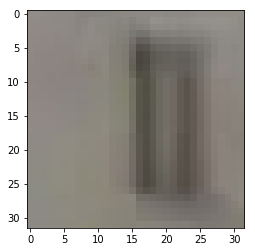

In [3]:
train_loader, valid_loader, test_loader = get_data_loader("svhn", batch_size)

# Show an image
real_sample, target = next(iter(train_loader))

showImg(real_sample[0])

In [ ]:
def train(loader):
    d_train_loss = 0
    
    for epoch in range(num_epoch):
        
        for data_idx, real_sample in enumerate(loader):
            G.train()
            D.train()
            
            step = epoch * len(loader) + data_idx + 1
            
            # Train more the dicriminator
            d_optim.zero_grad()
            g_optim.zero_grad()
    
            z = Variable(torch.randn(batch_size, z_size, device=device))
            
            fake_sample = G(z)
            real_sample = real_sample.to(device)
            
            d_loss = D.loss(real_sample, fake_sample)
            d_loss.backward()
            d_optim.step()
    
            if step % n_critic == 0:
                # Train the generator
                d_optim.zero_grad()
                g_optim.zero_grad()
            
                z = Variable(torch.randn(batch_size, z_size, device=device))
            
                fake_sample = G(z)
                fake_result = D(fake_sample)
                g_loss = G.loss(fake_result)
                g_loss.backward()
                g_optim.step()
                
        print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, d_train_loss / len(loader.dataset)))
        
        createSample(G)

In [ ]:
def createSample(generator):
    generator.eval()
    
    z = Variable(torch.randn(z_size, device=device))
    im = generator(z)
    showImg(im)

In [ ]:
train(train_loader)

## VAE training

In [194]:
def saveImg(x, name):
    save_dir = 'sample/'
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    torchvision.utils.save_image(x, save_dir+name)


def sampleLatentVariables(model):
    return Variable(torch.randn(1, z_size, device=device))

    
def generateImageWithVAE(model, name, z=None, save=True):
    if z is None:
        z = sampleLatentVariables(model)
    model.eval()
    x = model.decode(z)
    x = x.squeeze()
    x = x * 0.5 + 0.5
    if save:
        saveImg(x, name)
    x = x.permute(1, 2, 0)
    plt.imshow(x.cpu().detach().numpy())

In [136]:
def ELBO_loss_function(recon_x, x, mu, logvar):
    # ELBO: L(θ, φ; x) = -E_z~q_φ[log p_θ(x|z)] + D_KL(q_φ(z|x)||p(z))
    # reconstruction loss + regularizer (forcing the encoder's output to stay close to a standard Normal distribution)
    # BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    MSE = nn.MSELoss(reduction='sum')(recon_x, x)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    batch_size = x.shape[0]
    
    return (MSE + KLD) / batch_size


def train_vae(model, epoch, train_loader, optimizer):
    model.train()
    nb_examples = 0
    train_loss = 0
    for batch_idx, (data, y) in enumerate(train_loader):
        data = data.to(device)
        if model.type == 'SVHN-FC':
            data = data.view(-1, 3072)
        optimizer.zero_grad()
        batch_size = data.shape[0]
        recon_batch, mu, logvar = model(data)
        if model.type == 'SVHN-FC':
            data = data.view(-1, 3, 32, 32)
        loss = ELBO_loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item() * batch_size
        nb_examples += batch_size
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item()))

    print('====> Epoch: {} Average training loss: {:.4f}'.format(
          epoch, train_loss / nb_examples))
    
    return train_loss / nb_examples

    
def test_vae(model, epoch, data_loader):
    model.eval()
    nb_examples = 0
    test_loss = 0
    for batch_idx, (data, y) in enumerate(data_loader):
        data = data.to(device)
        if model.type == 'SVHN-FC':
            data = data.view(-1, 3072)
        batch_size = data.shape[0]
        recon_batch, mu, logvar = model(data)
        if model.type == 'SVHN-FC':
            data = data.view(-1, 3, 32, 32)
        loss = ELBO_loss_function(recon_batch, data, mu, logvar)
        test_loss += loss.item() * batch_size
        nb_examples += batch_size
#         if batch_idx % 100 == 0:
#             print('Validation Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(data_loader.dataset),
#                 100. * batch_idx / len(data_loader),
#                 loss.item()))

    print('====> Epoch: {} Average validation loss: {:.4f}'.format(
          epoch, test_loss / nb_examples))
    
    return test_loss / nb_examples

Train Epoch: 0 [0/65931 (0%)]	Loss: 629.496582
Train Epoch: 0 [6400/65931 (10%)]	Loss: 223.010666
Train Epoch: 0 [12800/65931 (19%)]	Loss: 168.644455
Train Epoch: 0 [19200/65931 (29%)]	Loss: 154.553101
Train Epoch: 0 [25600/65931 (39%)]	Loss: 168.070923
Train Epoch: 0 [32000/65931 (48%)]	Loss: 165.460205
Train Epoch: 0 [38400/65931 (58%)]	Loss: 149.544846
Train Epoch: 0 [44800/65931 (68%)]	Loss: 140.911865
Train Epoch: 0 [51200/65931 (78%)]	Loss: 133.640274
Train Epoch: 0 [57600/65931 (87%)]	Loss: 140.069351
Train Epoch: 0 [64000/65931 (97%)]	Loss: 143.605240
====> Epoch: 0 Average training loss: 172.7661
====> Epoch: 0 Average validation loss: 125.5283
Train Epoch: 1 [0/65931 (0%)]	Loss: 130.430145
Train Epoch: 1 [6400/65931 (10%)]	Loss: 134.526947
Train Epoch: 1 [12800/65931 (19%)]	Loss: 130.588287
Train Epoch: 1 [19200/65931 (29%)]	Loss: 127.075180
Train Epoch: 1 [25600/65931 (39%)]	Loss: 138.310623
Train Epoch: 1 [32000/65931 (48%)]	Loss: 114.982452
Train Epoch: 1 [38400/65931 (58%

Train Epoch: 12 [32000/65931 (48%)]	Loss: 96.439301
Train Epoch: 12 [38400/65931 (58%)]	Loss: 111.918633
Train Epoch: 12 [44800/65931 (68%)]	Loss: 114.648285
Train Epoch: 12 [51200/65931 (78%)]	Loss: 99.554962
Train Epoch: 12 [57600/65931 (87%)]	Loss: 105.494461
Train Epoch: 12 [64000/65931 (97%)]	Loss: 95.803261
====> Epoch: 12 Average training loss: 104.4148
====> Epoch: 12 Average validation loss: 92.5283
Train Epoch: 13 [0/65931 (0%)]	Loss: 100.524727
Train Epoch: 13 [6400/65931 (10%)]	Loss: 104.551949
Train Epoch: 13 [12800/65931 (19%)]	Loss: 123.475624
Train Epoch: 13 [19200/65931 (29%)]	Loss: 110.197205
Train Epoch: 13 [25600/65931 (39%)]	Loss: 102.086380
Train Epoch: 13 [32000/65931 (48%)]	Loss: 102.449799
Train Epoch: 13 [38400/65931 (58%)]	Loss: 107.548660
Train Epoch: 13 [44800/65931 (68%)]	Loss: 105.652580
Train Epoch: 13 [51200/65931 (78%)]	Loss: 92.953476
Train Epoch: 13 [57600/65931 (87%)]	Loss: 91.351067
Train Epoch: 13 [64000/65931 (97%)]	Loss: 100.826561
====> Epoch: 

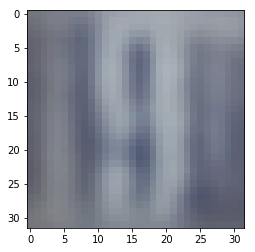

In [140]:
losses = []
for epoch in range(20):
    train_loss = train_vae(vae_model, epoch, train_loader, vae_optim)
    test_loss = test_vae(vae_model, epoch, valid_loader)
    losses.append((train_loss, test_loss))
    generateImageWithVAE(vae_model, f"VAE_{vae_model.type}_epoch_{epoch}.jpg")

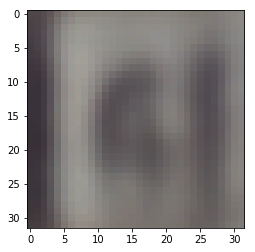

In [141]:
for i in range(1000):
    generateImageWithVAE(vae_model, f"VAE_{vae_model.type}_20epochs_{i}.jpg")

In [126]:
torch.save(vae_model.state_dict(), 'vae_svhn_conv_50.pt')

In [143]:
training_losses = [172.7661, 130.1618, 120.0547, 115.7088, 113.3657, 110.8276, 110.1157, 108.4359, 107.5871, 106.5133, 105.2977, 105.0857, 104.4148, 103.7058, 102.8021, 102.6295, 101.5502, 100.9595, 101.1159, 100.4673]
validation_losses = [125.5283, 110.1274, 103.8085, 100.8774, 99.9266, 102.4813, 99.8931, 100.0699, 96.6914, 95.7191, 94.9678, 94.9171, 92.5283, 95.6563, 92.3934, 93.7364, 93.1792, 95.0700, 91.7970, 90.7834]

## Latent variables perturbation

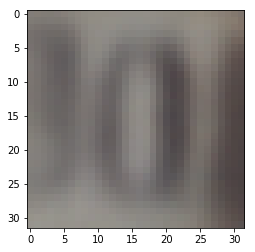

In [242]:
# latent_variables = sampleLatentVariables(vae_model)
generateImageWithVAE(vae_model, f"{vae_model.type}_unperturbed.jpg", latent_variables, True)

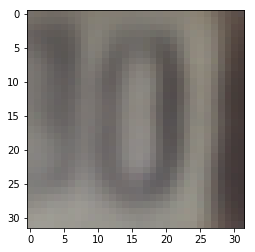

In [239]:
# perturbate every dimension one at a time
for i in range(latent_variables.shape[1]):
    perturbed_latent_variables = latent_variables.clone()
    if perturbed_latent_variables[0, i] < 0:
        perturbed_latent_variables[0, i] += 2
    else:
        perturbed_latent_variables[0, i] -= 2
    generateImageWithVAE(vae_model, f"{vae_model.type}_{i}_perturbed.jpg", perturbed_latent_variables, True)

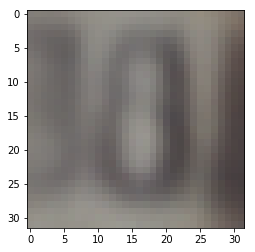

In [241]:
# perturbate chosen dimensions
strongest_dimensions = [1, 6, 29, 36, 40, 63, 68, 77, 86, 96]
for i in strongest_dimensions:
    perturbed_latent_variables_1 = latent_variables.clone()
    perturbed_latent_variables_2 = latent_variables.clone()
    perturbed_latent_variables_1[0, i] -= 2
    perturbed_latent_variables_2[0, i] += 2
    generateImageWithVAE(vae_model, f"{vae_model.type}_{i}_perturbed_1.jpg", perturbed_latent_variables_1, True)
    generateImageWithVAE(vae_model, f"{vae_model.type}_{i}_perturbed_2.jpg", perturbed_latent_variables_2, True)

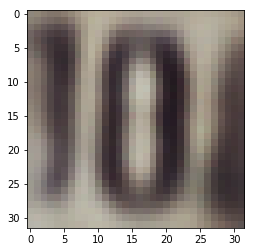

In [264]:
# create an improved image
perturbed_latent_variables = latent_variables.clone()
perturbed_latent_variables[0, 29] += 4  # increase sharpness
perturbed_latent_variables[0, 40] += 1  # more round shape
perturbed_latent_variables[0, 86] -= 1  # less artifacts
generateImageWithVAE(vae_model, f"{vae_model.type}_manually_improved_image.jpg", perturbed_latent_variables, True)

## Image interpolations

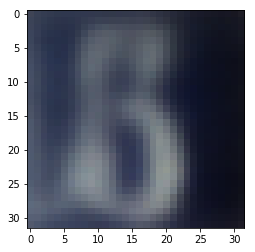

In [288]:
z1 = sampleLatentVariables(vae_model)
generateImageWithVAE(vae_model, f"{vae_model.type}_z1.jpg", z1, False)

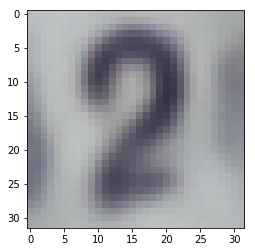

In [289]:
z2 = sampleLatentVariables(vae_model)
generateImageWithVAE(vae_model, f"{vae_model.type}_z2.jpg", z2, False)

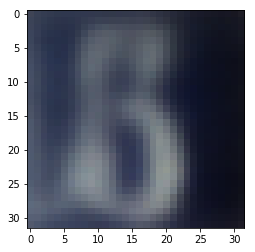

In [290]:
# z interpolation
for i in range(11):
    alpha = i * 0.1
    z_interpolated = alpha * z1 + (1 - alpha) * z2
    generateImageWithVAE(vae_model, f"{vae_model.type}_z_interpolated_alpha_{i}.jpg", z_interpolated, True)

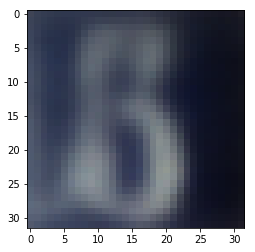

In [294]:
# x interpolation
for i in range(11):
    alpha = i * 0.1
    vae_model.eval()
    x1 = vae_model.decode(z1)
    x2 = vae_model.decode(z2)
    x1 = x1.squeeze()
    x2 = x2.squeeze()
    x1 = x1 * 0.5 + 0.5
    x2 = x2 * 0.5 + 0.5
    x_interpolated = alpha * x1 + (1 - alpha) * x2
    saveImg(x_interpolated, f"{vae_model.type}_x_interpolated_alpha_{i}.jpg")
    x_interpolated = x_interpolated.permute(1, 2, 0)
    plt.imshow(x_interpolated.cpu().detach().numpy())